# FaceID recreation using face embeddings and RGBD images.
Made by [Norman Di Palo](https://medium.com/@normandipalo), March 2018.

# Let's start by downloading the dataset.

In [2]:
!rm -r faceid_train
!rm -r faceid_val

rm: cannot remove 'faceid_train': No such file or directory
rm: cannot remove 'faceid_val': No such file or directory


In [3]:
!ls

datalab


In [0]:
!mkdir faceid_train
!mkdir faceid_val

In [5]:
# https://keras.io/
!pip install -U keras
import keras

    100% |████████████████████████████████| 337kB 2.3MB/s 
    100% |████████████████████████████████| 50.0MB 27kB/s 
    100% |████████████████████████████████| 256kB 3.4MB/s 
Requirement already up-to-date: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from keras)
    100% |████████████████████████████████| 12.2MB 114kB/s 
  Running setup.py bdist_wheel for pyyaml ... - \ done
  Stored in directory: /content/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
  Found existing installation: numpy 1.14.0
    Uninstalling numpy-1.14.0:
      Successfully uninstalled numpy-1.14.0
  Found existing installation: scipy 0.19.1
    Uninstalling scipy-0.19.1:
      Successfully uninstalled scipy-0.19.1
  Found existing installation: PyYAML 3.11
    Uninstalling PyYAML-3.11:
      Successfully uninstalled PyYAML-3.11


Using TensorFlow backend.


In [0]:
link_list=["http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(151751).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(153054).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(154211).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(160440).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(160931).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(161342).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(163349).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(164248).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-17)(141550).zip", \
          "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-17)(142154).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-17)(142457).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-17)(143016).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(132824).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(133201).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(133846).zip", \
          "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(134239).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(134757).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(140516).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(143345).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(144316).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(145150).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(145623).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(150303).zip", \
          "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(150650).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(151337).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(151650).zip"]
val_list=["http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(152717).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(153532).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(154129).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(154728).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(155357).zip"]

In [0]:
import requests, zipfile, io
for link in link_list:
  r = requests.get(link, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall("faceid_train")
for link in val_list:
  r = requests.get(link, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall("faceid_val")

# Input preprocessing.
Here we create some functions that will create the input couple for our model, both correct and wrong couples. I created functions to have both depth-only input and RGBD inputs.

In [0]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
def create_couple(file_path):
    folder=np.random.choice(glob.glob(file_path + "*"))
    while folder == "datalab":
      folder=np.random.choice(glob.glob(file_path + "*"))
  #  print(folder)
    mat=np.zeros((480,640), dtype='float32')
    i=0
    j=0
    depth_file = np.random.choice(glob.glob(folder + "/*.dat"))
    with open(depth_file) as file:
        for line in file:
            vals = line.split('\t')
            for val in vals:
                if val == "\n": continue 
                if int(val) > 1200 or int(val) == -1: val= 1200
                mat[i][j]=float(int(val))
                j+=1
                j=j%640

            i+=1
        mat = np.asarray(mat)
    mat_small=mat[140:340,220:420]
    mat_small=(mat_small-np.mean(mat_small))/np.max(mat_small)
#    plt.imshow(mat_small)
#    plt.show()
    
    mat2=np.zeros((480,640), dtype='float32')
    i=0
    j=0
    depth_file = np.random.choice(glob.glob(folder + "/*.dat"))
    with open(depth_file) as file:
        for line in file:
            vals = line.split('\t')
            for val in vals:
                if val == "\n": continue 
                if int(val) > 1200 or int(val) == -1: val= 1200
                mat2[i][j]=float(int(val))
                j+=1
                j=j%640

            i+=1
        mat2 = np.asarray(mat2)
    mat2_small=mat2[140:340,220:420]
    mat2_small=(mat2_small-np.mean(mat2_small))/np.max(mat2_small)
#    plt.imshow(mat2_small)
#    plt.show()
    return np.array([mat_small, mat2_small])

In [11]:
print(create_couple("faceid_train/"))

[[[ 0.10215505  0.10215505  0.10215505 ...  0.10215505  0.10215505
    0.10215505]
  [ 0.10215505  0.10215505  0.10215505 ...  0.10215505  0.10215505
    0.10215505]
  [ 0.10215505  0.10215505  0.10215505 ...  0.10215505  0.10215505
    0.10215505]
  ...
  [-0.06117828 -0.06117828 -0.06367829 ...  0.10215505  0.10215505
    0.10215505]
  [-0.06367829 -0.06617828 -0.06617828 ...  0.10215505  0.10215505
    0.10215505]
  [-0.06617828 -0.06617828 -0.06867828 ...  0.10215505  0.10215505
    0.10215505]]

 [[ 0.09494985  0.09494985  0.09494985 ...  0.09494985  0.09494985
    0.09494985]
  [ 0.09494985  0.09494985  0.09494985 ...  0.09494985  0.09494985
    0.09494985]
  [ 0.09494985  0.09494985  0.09494985 ...  0.09494985  0.09494985
    0.09494985]
  ...
  [-0.06338348 -0.06338348 -0.06588349 ...  0.09494985  0.09494985
    0.09494985]
  [-0.06588349 -0.06588349 -0.06588349 ...  0.09494985  0.09494985
    0.09494985]
  [-0.06588349 -0.06588349 -0.06838349 ...  0.09494985  0.09494985
    0.

In [0]:
def create_couple_rgbd(file_path):
    folder=np.random.choice(glob.glob(file_path + "*"))
    while folder == "datalab":
      folder=np.random.choice(glob.glob(file_path + "*"))
  #  print(folder)
    mat=np.zeros((480,640), dtype='float32')
    i=0
    j=0
    depth_file = np.random.choice(glob.glob(folder + "/*.dat"))
    with open(depth_file) as file:
        for line in file:
            vals = line.split('\t')
            for val in vals:
                if val == "\n": continue    
                if int(val) > 1200 or int(val) == -1: val= 1200
                mat[i][j]=float(int(val))
                j+=1
                j=j%640

            i+=1
        mat = np.asarray(mat)
    mat_small=mat[140:340,220:420]
    img = Image.open(depth_file[:-5] + "c.bmp")
    img.thumbnail((640,480))
    img = np.asarray(img)
    img = img[140:340,220:420]
    mat_small=(mat_small-np.mean(mat_small))/np.max(mat_small)
#    plt.imshow(mat_small)
#    plt.show()
#    plt.imshow(img)
#    plt.show()
    
    
    mat2=np.zeros((480,640), dtype='float32')
    i=0
    j=0
    depth_file = np.random.choice(glob.glob(folder + "/*.dat"))
    with open(depth_file) as file:
        for line in file:
            vals = line.split('\t')
            for val in vals:
                if val == "\n": continue
                if int(val) > 1200 or int(val) == -1: val= 1200
                mat2[i][j]=float(int(val))
                j+=1
                j=j%640

            i+=1
        mat2 = np.asarray(mat2)
    mat2_small=mat2[140:340,220:420]
    img2 = Image.open(depth_file[:-5] + "c.bmp")
    img2.thumbnail((640,480))
    img2 = np.asarray(img2)
    img2 = img2[160:360,240:440]

 #   plt.imshow(img2)
 #   plt.show()
    mat2_small=(mat2_small-np.mean(mat2_small))/np.max(mat2_small)
 #   plt.imshow(mat2_small)
 #   plt.show()
    
    full1 = np.zeros((200,200,4))
    full1[:,:,:3] = img[:,:,:3]
    full1[:,:,3] = mat_small
    
    full2 = np.zeros((200,200,4))
    full2[:,:,:3] = img2[:,:,:3]
    full2[:,:,3] = mat2_small
    return np.array([full1, full2])

In [13]:
create_couple_rgbd("faceid_val/")

array([[[[ 1.85000000e+02,  1.75000000e+02,  1.49000000e+02,
           7.03941882e-02],
         [ 1.86000000e+02,  1.73000000e+02,  1.54000000e+02,
           7.03941882e-02],
         [ 1.87000000e+02,  1.73000000e+02,  1.54000000e+02,
           7.03941882e-02],
         ...,
         [ 1.65000000e+02,  1.62000000e+02,  1.45000000e+02,
           7.03941882e-02],
         [ 1.63000000e+02,  1.61000000e+02,  1.43000000e+02,
           7.03941882e-02],
         [ 1.62000000e+02,  1.60000000e+02,  1.41000000e+02,
           7.03941882e-02]],

        [[ 1.86000000e+02,  1.75000000e+02,  1.49000000e+02,
           7.03941882e-02],
         [ 1.87000000e+02,  1.72000000e+02,  1.52000000e+02,
           7.03941882e-02],
         [ 1.87000000e+02,  1.73000000e+02,  1.54000000e+02,
           7.03941882e-02],
         ...,
         [ 1.65000000e+02,  1.62000000e+02,  1.41000000e+02,
           7.03941882e-02],
         [ 1.65000000e+02,  1.61000000e+02,  1.39000000e+02,
           7.039418

In [0]:
def create_wrong(file_path):
    folder=np.random.choice(glob.glob(file_path + "*"))
    while folder == "datalab":
      folder=np.random.choice(glob.glob(file_path + "*"))    
    mat=np.zeros((480,640), dtype='float32')
    i=0
    j=0
    depth_file = np.random.choice(glob.glob(folder + "/*.dat"))
    with open(depth_file) as file:
        for line in file:
            vals = line.split('\t')
            for val in vals:
                if val == "\n": continue 
                if int(val) > 1200 or int(val) == -1: val= 1200
                mat[i][j]=float(int(val))
                j+=1
                j=j%640

            i+=1
        mat = np.asarray(mat)
    mat_small=mat[140:340,220:420]
    mat_small=(mat_small-np.mean(mat_small))/np.max(mat_small)
 #   plt.imshow(mat_small)
 #   plt.show()
    
    folder2=np.random.choice(glob.glob(file_path + "*"))
    while folder==folder2 or folder2=="datalab": #it activates if it chose the same folder
        folder2=np.random.choice(glob.glob(file_path + "*"))
    mat2=np.zeros((480,640), dtype='float32')
    i=0
    j=0
    depth_file = np.random.choice(glob.glob(folder2 + "/*.dat"))
    with open(depth_file) as file:
        for line in file:
            vals = line.split('\t')
            for val in vals:
                if val == "\n": continue
                if int(val) > 1200 or int(val) == -1: val= 1200
                mat2[i][j]=float(int(val))
                j+=1
                j=j%640

            i+=1
        mat2 = np.asarray(mat2)
    mat2_small=mat2[140:340,220:420]
    mat2_small=(mat2_small-np.mean(mat2_small))/np.max(mat2_small)
 #   plt.imshow(mat2_small)
 #   plt.show()
  
    
    return np.array([mat_small, mat2_small])

In [15]:
create_wrong("faceid_train/")

array([[[ 0.15714498,  0.15714498,  0.15714498, ...,  0.15714498,
          0.15714498,  0.15714498],
        [ 0.15714498,  0.15714498,  0.15714498, ...,  0.15714498,
          0.15714498,  0.15714498],
        [ 0.15714498,  0.15714498,  0.15714498, ...,  0.15714498,
          0.15714498,  0.15714498],
        ...,
        [-0.02285502, -0.02285502, -0.02285502, ..., -0.04785502,
         -0.04785502, -0.04535502],
        [-0.02285502, -0.02535502, -0.02535502, ..., -0.04952169,
         -0.04785502, -0.04785502],
        [-0.02785502, -0.02785502, -0.02952169, ..., -0.04952169,
         -0.04952169, -0.04952169]],

       [[ 0.06464213,  0.06464213,  0.06464213, ...,  0.06464213,
          0.06464213,  0.06464213],
        [ 0.06464213,  0.06464213,  0.06464213, ...,  0.06464213,
          0.06464213,  0.06464213],
        [ 0.06464213,  0.06464213,  0.06464213, ...,  0.06464213,
          0.06464213,  0.06464213],
        ...,
        [ 0.06464213,  0.06464213,  0.06464213, ...,  

In [0]:
def create_wrong_rgbd(file_path):
    folder=np.random.choice(glob.glob(file_path + "*"))
    while folder == "datalab":
      folder=np.random.choice(glob.glob(file_path + "*"))    
    mat=np.zeros((480,640), dtype='float32')
    i=0
    j=0
    depth_file = np.random.choice(glob.glob(folder + "/*.dat"))
    with open(depth_file) as file:
        for line in file:
            vals = line.split('\t')
            for val in vals:
                if val == "\n": continue
                if int(val) > 1200 or int(val) == -1: val= 1200
                mat[i][j]=float(int(val))
                j+=1
                j=j%640

            i+=1
        mat = np.asarray(mat)
    mat_small=mat[140:340,220:420]
    img = Image.open(depth_file[:-5] + "c.bmp")
    img.thumbnail((640,480))
    img = np.asarray(img)
    img = img[140:340,220:420]
    mat_small=(mat_small-np.mean(mat_small))/np.max(mat_small)
  #  plt.imshow(img)
  #  plt.show()
  #  plt.imshow(mat_small)
  #  plt.show()
    folder2=np.random.choice(glob.glob(file_path + "*"))
    while folder==folder2 or folder2=="datalab": #it activates if it chose the same folder
        folder2=np.random.choice(glob.glob(file_path + "*"))
    mat2=np.zeros((480,640), dtype='float32')
    i=0
    j=0
    depth_file = np.random.choice(glob.glob(folder2 + "/*.dat"))
    with open(depth_file) as file:
        for line in file:
            vals = line.split('\t')
            for val in vals:
                if val == "\n": continue 
                if int(val) > 1200 or int(val) == -1: val= 1200
                mat2[i][j]=float(int(val))
                j+=1
                j=j%640

            i+=1
        mat2 = np.asarray(mat2)
    mat2_small=mat2[140:340,220:420]
    img2 = Image.open(depth_file[:-5] + "c.bmp")
    img2.thumbnail((640,480))
    img2 = np.asarray(img2)
    img2 = img2[140:340,220:420]
    mat2_small=(mat2_small-np.mean(mat2_small))/np.max(mat2_small)
 #   plt.imshow(img2)
 #   plt.show()
 #   plt.imshow(mat2_small)
 #   plt.show()
    full1 = np.zeros((200,200,4))
    full1[:,:,:3] = img[:,:,:3]
    full1[:,:,3] = mat_small
    
    full2 = np.zeros((200,200,4))
    full2[:,:,:3] = img2[:,:,:3]
    full2[:,:,3] = mat2_small
    return np.array([full1, full2])

In [17]:
create_wrong_rgbd("faceid_val/")[0].shape

(200, 200, 4)

# Network crafting.
Now we create the network. We first manually create the *constrative loss*, then we define the network architecture starting from the SqueezeNet architecture, and then using it as a siamese-network for embedding faces into a manifold. (the network for now is very big and could be heavily optimized, but I just wanted to show a proof-of-concept)

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, ELU, concatenate, GlobalAveragePooling2D, Input, BatchNormalization, SeparableConv2D, Subtract, concatenate
from keras.activations import relu, softmax
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras import backend as K

In [0]:
def euclidean_distance(inputs):
    assert len(inputs) == 2, \
        'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))
        

def contrastive_loss(y_true,y_pred):
    margin=1.
    return K.mean((1. - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.)))
   # return K.mean( K.square(y_pred) )

In [0]:
def fire(x, squeeze=16, expand=64):
    x = Convolution2D(squeeze, (1,1), padding='valid')(x)
    x = Activation('relu')(x)
    
    left = Convolution2D(expand, (1,1), padding='valid')(x)
    left = Activation('relu')(left)
    
    right = Convolution2D(expand, (3,3), padding='same')(x)
    right = Activation('relu')(right)
    
    x = concatenate([left, right], axis=3)
    return x

In [26]:

img_input=Input(shape=(200,200,4))

x = Convolution2D(64, (5, 5), strides=(2, 2), padding='valid')(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = fire(x, squeeze=16, expand=16)

x = fire(x, squeeze=16, expand=16)

x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)


x = fire(x, squeeze=32, expand=32)

x = fire(x, squeeze=32, expand=32)

x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)


x = fire(x, squeeze=48, expand=48)

x = fire(x, squeeze=48, expand=48)

x = fire(x, squeeze=64, expand=64)

x = fire(x, squeeze=64, expand=64)

x = Dropout(0.2)(x)

x = Convolution2D(512, (1, 1), padding='same')(x)
out = Activation('relu')(x)


modelsqueeze= Model(img_input, out)

modelsqueeze.summary()




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 98, 98, 64)   6464        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 98, 98, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 98, 98, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [27]:
im_in = Input(shape=(200,200,4))
#wrong = Input(shape=(200,200,3))

x1 = modelsqueeze(im_in)
#x = Convolution2D(64, (5, 5), padding='valid', strides =(2,2))(x)

#x1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x1)

"""
x1 = Convolution2D(256, (3,3), padding='valid', activation="relu")(x1)
x1 = Dropout(0.4)(x1)

x1 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1))(x1)

x1 = Convolution2D(256, (3,3), padding='valid', activation="relu")(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.4)(x1)

x1 = Convolution2D(64, (1,1), padding='same', activation="relu")(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.4)(x1)
"""



x1 = Flatten()(x1)

x1 = Dense(512, activation="relu")(x1)
x1 = Dropout(0.2)(x1)
#x1 = BatchNormalization()(x1)
feat_x = Dense(128, activation="linear")(x1)
feat_x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(feat_x)


model_top = Model(inputs = [im_in], outputs = feat_x)

model_top.summary()

im_in1 = Input(shape=(200,200,4))
im_in2 = Input(shape=(200,200,4))

feat_x1 = model_top(im_in1)
feat_x2 = model_top(im_in2)


lambda_merge = Lambda(euclidean_distance)([feat_x1, feat_x2])


model_final = Model(inputs = [im_in1, im_in2], outputs = lambda_merge)

model_final.summary()

adam = Adam(lr=0.001)

sgd = SGD(lr=0.001, momentum=0.9)

model_final.compile(optimizer=adam, loss=contrastive_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 4)       0         
_________________________________________________________________
model_1 (Model)              (None, 11, 11, 512)       253952    
_________________________________________________________________
flatten_1 (Flatten)          (None, 61952)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               31719936  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
lambda_1 (Lambda)            (None, 128)               0         
Total para

# Learning phase.
We write the generators that will give our model batches of data to train on, then we run the training.

In [0]:
def generator(batch_size):
  
  while 1:
    X=[]
    y=[]
    switch=True
    for _ in range(batch_size):
   #   switch += 1
      if switch:
     #   print("correct")
        X.append(create_couple_rgbd("faceid_train/").reshape((2,200,200,4)))
        y.append(np.array([0.]))
      else:
     #   print("wrong")
        X.append(create_wrong_rgbd("faceid_train/").reshape((2,200,200,4)))
        y.append(np.array([1.]))
      switch=not switch
    X = np.asarray(X)
    y = np.asarray(y)
    XX1=X[0,:]
    XX2=X[1,:]
    yield [X[:,0],X[:,1]],y

In [0]:
def val_generator(batch_size):
  
  while 1:
    X=[]
    y=[]
    switch=True
    for _ in range(batch_size):
      if switch:
        X.append(create_couple_rgbd("faceid_val/").reshape((2,200,200,4)))
        y.append(np.array([0.]))
      else:
        X.append(create_wrong_rgbd("faceid_val/").reshape((2,200,200,4)))
        y.append(np.array([1.]))
      switch=not switch
    X = np.asarray(X)
    y = np.asarray(y)
    XX1=X[0,:]
    XX2=X[1,:]
    yield [X[:,0],X[:,1]],y

In [0]:
gen = generator(16)
val_gen = val_generator(4)

In [0]:
outputs = model_final.fit_generator(gen, steps_per_epoch=30, epochs=50, validation_data = val_gen, validation_steps=20)

Epoch 1/50
30/30 [==============================] - 515s 17s/step - loss: 0.0994 - val_loss: 0.1148
Epoch 2/50
30/30 [==============================] - 425s 14s/step - loss: 0.0842 - val_loss: 0.0719
Epoch 3/50
 4/30 [===>..........................] - ETA: 11s - loss: 0.0794

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226792). Check your callbacks.
  % delta_t_median)


 5/30 [====>.........................] - ETA: 10s - loss: 0.0912

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233295). Check your callbacks.
  % delta_t_median)


30/30 [==============================] - 427s 14s/step - loss: 0.0841 - val_loss: 0.1185
Epoch 4/50
30/30 [==============================] - 438s 15s/step - loss: 0.0748 - val_loss: 0.0817
Epoch 5/50
30/30 [==============================] - 444s 15s/step - loss: 0.0752 - val_loss: 0.1171
Epoch 6/50
30/30 [==============================] - 439s 15s/step - loss: 0.0704 - val_loss: 0.0689
Epoch 7/50
30/30 [==============================] - 434s 14s/step - loss: 0.0776 - val_loss: 0.0992
Epoch 8/50
30/30 [==============================] - 438s 15s/step - loss: 0.0800 - val_loss: 0.0904
Epoch 9/50
 5/30 [====>.........................] - ETA: 11s - loss: 0.0760

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245728). Check your callbacks.
  % delta_t_median)


26/30 [=========================>....] - ETA: 40s - loss: 0.0728

KeyboardInterrupt: ignored

# Some model tests.


In [0]:
cop = create_couple("faceid_val/")
model_final.evaluate([cop[0].reshape((1,200,200,1)), cop[1].reshape((1,200,200,1))], np.array([0.]))

NameError: ignored

In [0]:
cop = create_wrong_rgbd("faceid_val/")
model_final.predict([cop[0].reshape((1,200,200,4)), cop[1].reshape((1,200,200,4))])

array([[1.4120153]], dtype=float32)

# Saving and loading the model.
The next cells show both how to save the model weights and upload them into your Drive, and then how to retrieve those weights from the Drive to load a pre-trained model.

In [0]:
model_final.save("faceid_big_rgbd_2.h5")

In [0]:
from google.colab import files

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'faceid_big_rgbd.h5'})
uploaded.SetContentFile('faceid_big_rgbd.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 17Lo_ZxYcKO751iYs4XRyIvVXME8Lyc75


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '17Lo_ZxYcKO751iYs4XRyIvVXME8Lyc75'
downloaded = drive.CreateFile({'id': file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [0]:
downloaded.GetContentFile('pesi.h5')

In [0]:
from keras.models import load_model


In [0]:
model_final.load_weights('pesi.h5')


# Raw output.
Here we create a model that outputs the embedding of an input face instead of the distance between two embeddings, so we can map those outputs.

In [31]:
im_in1 = Input(shape=(200,200,4))
#im_in2 = Input(shape=(200,200,4))

feat_x1 = model_top(im_in1)
#feat_x2 = model_top(im_in2)



model_output = Model(inputs = im_in1, outputs = feat_x1)

model_output.summary()

adam = Adam(lr=0.001)

sgd = SGD(lr=0.001, momentum=0.9)

model_output.compile(optimizer=adam, loss=contrastive_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 200, 200, 4)       0         
_________________________________________________________________
model_2 (Model)              (None, 128)               32039552  
Total params: 32,039,552
Trainable params: 32,039,424
Non-trainable params: 128
_________________________________________________________________


In [32]:
cop = create_couple_rgbd("faceid_val/")
model_output.predict(cop[0].reshape((1,200,200,4)))

array([[ 0.16414395, -0.13870355,  0.01013375,  0.00533672,  0.12819481,
         0.00950897,  0.0581798 ,  0.0125026 , -0.14719632, -0.0320079 ,
         0.07111354,  0.05890286,  0.00266691, -0.01223555, -0.00381333,
         0.00116326,  0.04405256,  0.07326933, -0.02592516, -0.05166509,
         0.18017435, -0.06742426,  0.04962699,  0.105292  , -0.0898006 ,
         0.0411743 ,  0.11524671, -0.16427691, -0.07334423, -0.08005075,
         0.12541303, -0.22259332,  0.05284468, -0.09389317, -0.04294442,
        -0.05872821,  0.10885703, -0.1348703 ,  0.16432703,  0.04767004,
         0.14579478,  0.02009899,  0.02733266, -0.07123698,  0.13352446,
        -0.07614288, -0.03760444,  0.05777392,  0.10022782,  0.04174699,
         0.06108676,  0.04703509, -0.05310335, -0.0403618 ,  0.12924859,
        -0.00420733,  0.06204433,  0.02973575, -0.08997695,  0.04855238,
         0.01506527, -0.07634371,  0.09674198, -0.05066067,  0.13670339,
         0.08011758, -0.04623083, -0.00054593,  0.0

In [0]:
def create_input_rgbd(file_path):
  #  print(folder)
    mat=np.zeros((480,640), dtype='float32')
    i=0
    j=0
    depth_file = file_path
    with open(depth_file) as file:
        for line in file:
            vals = line.split('\t')
            for val in vals:
                if val == "\n": continue    
                if int(val) > 1200 or int(val) == -1: val= 1200
                mat[i][j]=float(int(val))
                j+=1
                j=j%640

            i+=1
        mat = np.asarray(mat)
    mat_small=mat[140:340,220:420]
    img = Image.open(depth_file[:-5] + "c.bmp")
    img.thumbnail((640,480))
    img = np.asarray(img)
    img = img[140:340,220:420]
    mat_small=(mat_small-np.mean(mat_small))/np.max(mat_small)
    plt.figure(figsize=(8,8))
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mat_small)
    plt.show()
    plt.figure(figsize=(8,8))
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()
    
    
    
    full1 = np.zeros((200,200,4))
    full1[:,:,:3] = img[:,:,:3]
    full1[:,:,3] = mat_small
    
    return np.array([full1])

# Data visualization.
Here we store the embeddings for all the faces in the dataset. Then, using both **t-SNE** and **PCA**, we visualize the embeddings going from 128 to 2 dimensions. 

In [0]:
outputs=[]
n=0
for folder in glob.glob('faceid_train/*'):
  i=0
  for file in glob.glob(folder + '/*.dat'):
    i+=1
    outputs.append(model_output.predict(create_input_rgbd(file).reshape((1,200,200,4))))
  print(i)
  n+=1
  print("Folder ", n, " of ", len(glob.glob('faceid_train/*')))
print(len(outputs))

51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
51
Folder  1  of  26
1326


In [0]:
outputs= np.asarray(outputs)
outputs = outputs.reshape((-1,128))
outputs.shape

(1326, 128)

In [0]:
import sklearn
from sklearn.manifold import TSNE


In [0]:
X_embedded = TSNE(2).fit_transform(outputs)
X_embedded.shape

(1326, 2)

In [0]:
import numpy as np
from sklearn.decomposition import PCA

X_PCA = PCA(3).fit_transform(outputs)
print(X_PCA.shape)

#X_embedded = TSNE(2).fit_transform(X_PCA)
#print(X_embedded.shape)

(1326, 3)


In [0]:
import matplotlib.pyplot as plt

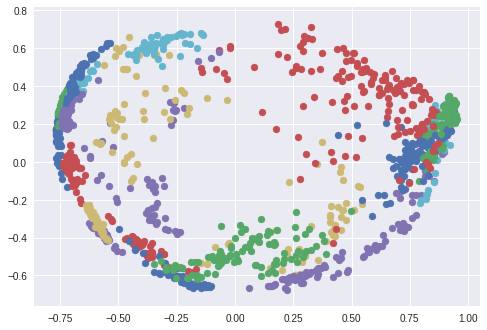

In [0]:
color = 0
for i in range(len((X_embedded))):
  el = X_embedded[i]
  if i % 51 == 0 and not i==0:
    color+=1
    color=color%10
  plt.scatter(el[0], el[1], color="C" + str(color))

# Distance between two arbitrary RGBD pictures.

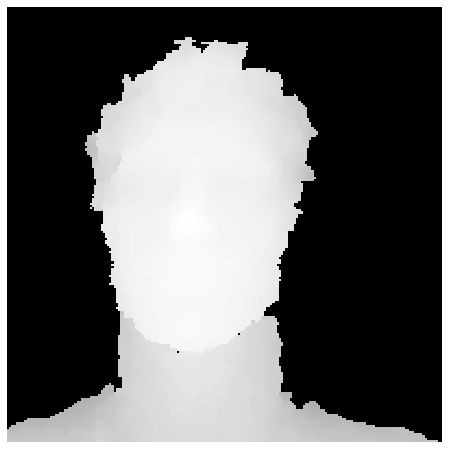

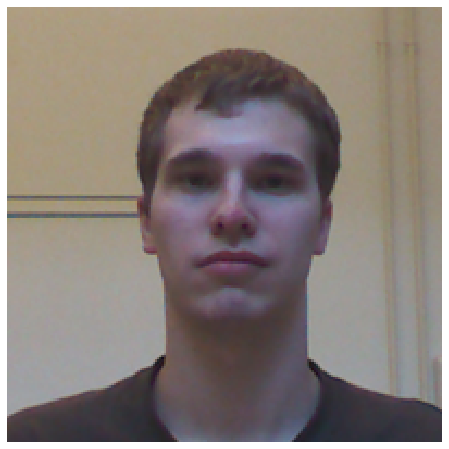

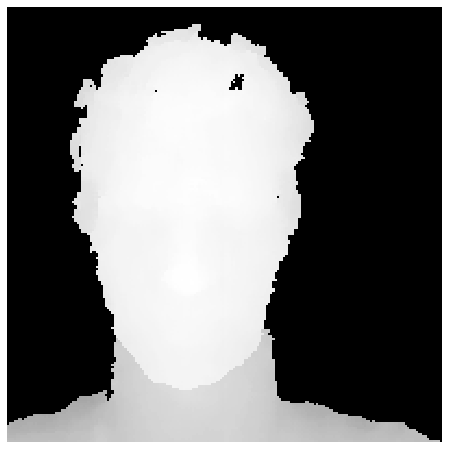

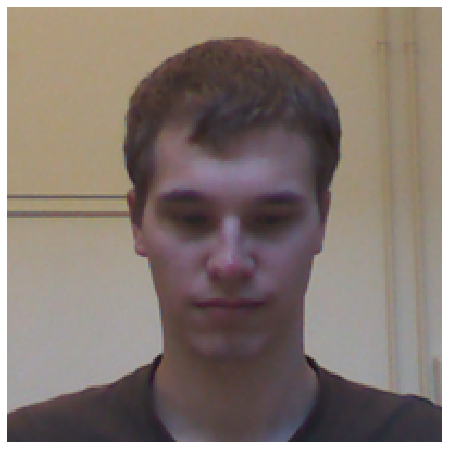

array([[0.30020022]], dtype=float32)

In [74]:

file1 = ('faceid_train/(2012-05-16)(154211)/015_1_d.dat')
inp1 = create_input_rgbd(file1)
file1 = ('faceid_train/(2012-05-16)(154211)/011_1_d.dat')
inp2 = create_input_rgbd(file1)

model_final.predict([inp1, inp2])
